In [59]:
import matplotlib.pyplot as plt
import pandas
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import tree

df = pd.read_excel("Ipsos_Datovy_soubor_18122020.xlsx", header=None, sheet_name="Export 1")

col_headers = []
df_cleaned = pandas.DataFrame()


def convert_output_value(value):
    if "není důležité" in str(value):
        return -1
    if "je důležité" in str(value):
        return 1
    if value == "Ani tak, ani tak.":
        return 0
    print(value)

def convert_output_value_know(value):
    if value == "Nikdy jsem o něm neslyšel(a).":
        return 0
    if value == "Pouze jsem o něm slyšel(a), ale nic o něm nevím.":
        return 1
    if value == "Mám o něm pouze základní informace.":
        return 2
    if value == "Znám ho poměrně dobře.":
        return 3
    if value == "Znám ho velmi dobře.":
        return 3

OUTPUT_COLUMN = "Do jaké míry jste obeznámen(a) s pojmem sociální podnikání?"
# "Do jaké míry považujete sociální podnikání za důležité pro naplňování veřejně prospěšných cílů?"
# "Do jaké míry jste obeznámen(a) s pojmem sociální podnikání?"

columns = []
for col in df:
    actual_col_name = ""
    data_row = []
    row_0 = df[col].iloc[0]
    row_1 = df[col].iloc[1]
    if row_0 == "Demografické kategorie" and row_1 == "Věk":
        actual_col_name = "Věk"
    elif row_0 == OUTPUT_COLUMN:
        actual_col_name = "Output"
    elif row_1 in ("Velikost místa bydliště", "Kraj", "Vzdělání", "Pohlaví"):
        actual_col_name = row_1
    if actual_col_name != "":
        col_headers.append(actual_col_name)
        col_content = df[col]
        if actual_col_name == "Output":
            df_cleaned[actual_col_name] = col_content.map(convert_output_value_know)
        elif actual_col_name in ("Velikost místa bydliště", "Kraj", "Vzdělání"):
            one_hot = pd.get_dummies(col_content)
            df_cleaned = df_cleaned.join(one_hot)
        elif actual_col_name == "Pohlaví":
            df_cleaned[actual_col_name] = col_content.map(lambda x: int(x == "Žena"))

df_cleaned = df_cleaned[~df_cleaned["Output"].isna()]
# df_cleaned = df_cleaned[df_cleaned["Output"] != 0]
df_cleaned_X = df_cleaned.drop(columns="Output")
df_cleaned_Y = df_cleaned["Output"]
df_cleaned.head()

,Pohlaví,Jihomoravský,Jihočeský,Karlovarský,Kraj,Královehradecký,Liberecký,Moravskoslezský,Olomoucký,Pardubický,...,5 001 až 20 000 obyvatel,Do 1000 obyvatel,Velikost místa bydliště,Více než 100 000 obyvatel,SŠ,Vyučen/a,Vzdělání,VŠ,ZŠ,Output
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1.0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,2.0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,2.0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,3.0
6,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0.0


| Odpověď                                            | Klasifikace |
|----------------------------------------------------|-------------|
| "Nikdy jsem o něm neslyšel(a)."                    | 0           |
| "Pouze jsem o něm slyšel(a), ale nic o něm nevím." | 1           |
| "Mám o něm pouze základní informace."              | 2           |
| "Znám ho poměrně dobře."                           | 3           |
| "Znám ho velmi dobře."                             | 3           |

In [70]:
clf = tree.DecisionTreeClassifier(max_depth=4, criterion="log_loss")
clf = clf.fit(df_cleaned_X, df_cleaned_Y)

In [66]:
df_columns = list(zip(range(0, len(df_cleaned_X.columns)),  df_cleaned_X.columns))
df_columns = pandas.DataFrame(df_columns)
df_columns.to_excel("columns.xlsx", index=False)

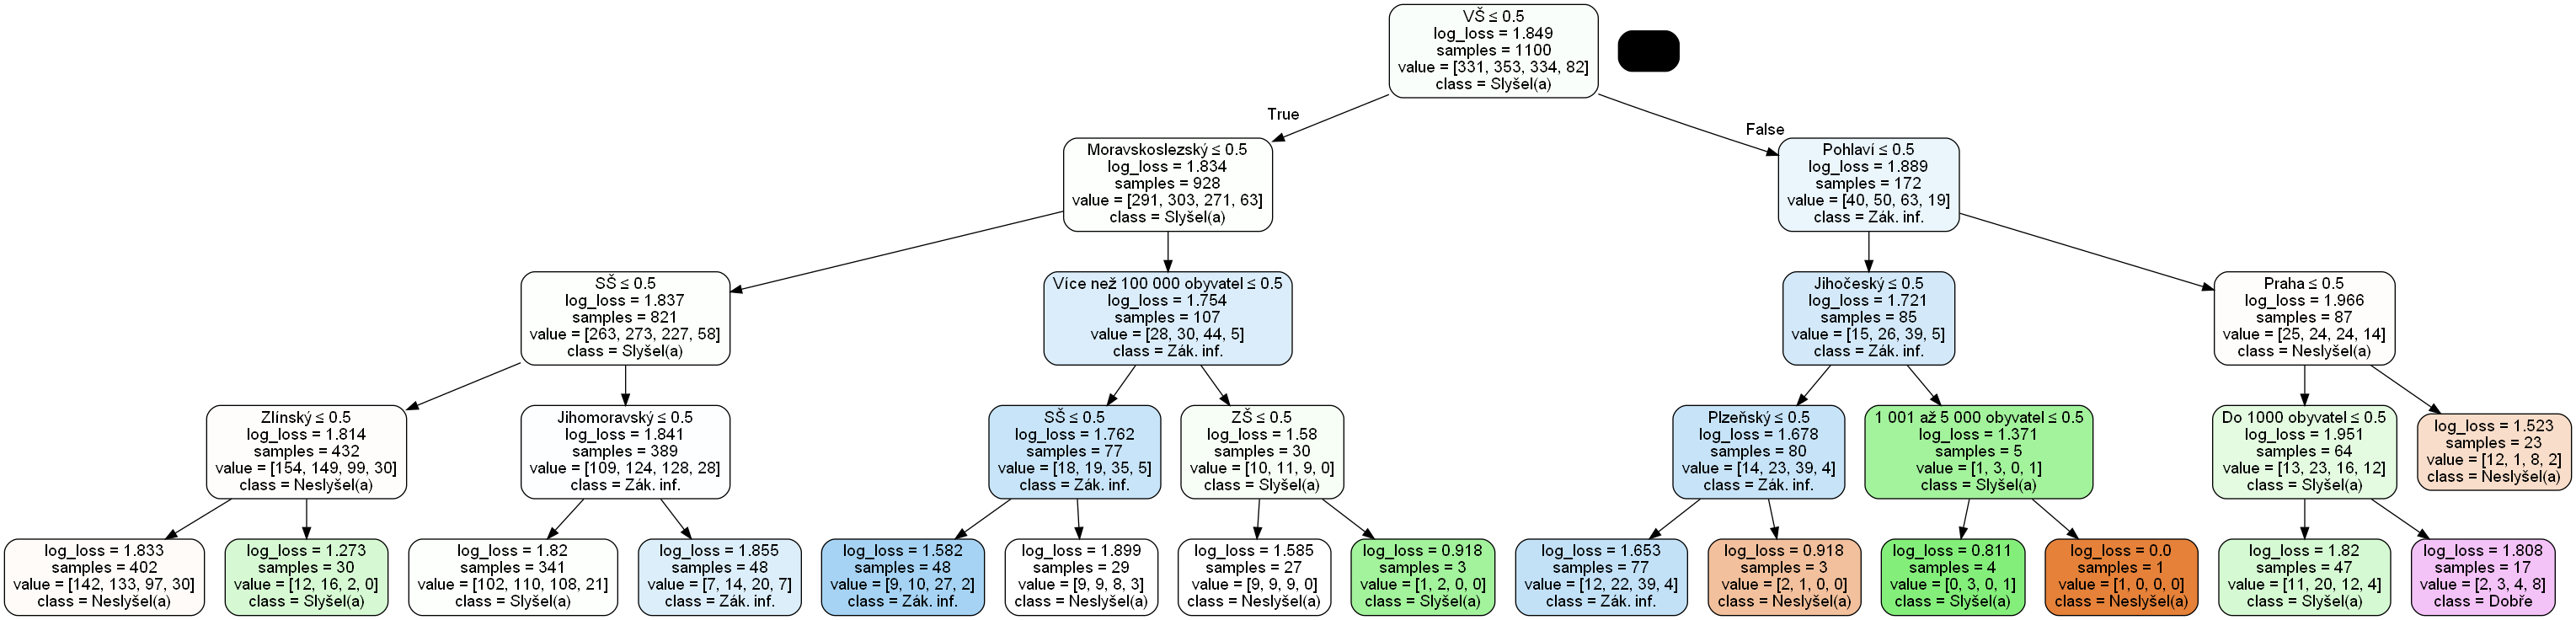

In [72]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

# https://www.datacamp.com/tutorial/decision-tree-classification-python

feature_cols = df_cleaned_X.columns

class_names = ["Neslyšel(a)",  "Slyšel(a)",  "Zák. inf.",  "Dobře"]

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=class_names)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('classification.png')
Image(graph.create_png())